### Задачи к Лекции 4

__Исходные данные__ 

Дан файл **"mlbootcamp5_train.csv"**. В нем содержатся данные об опросе 70000 пациентов с целью определения наличия заболеваний сердечно-сосудистой системы (ССЗ). Данные в файле промаркированы и если у человека имееются ССЗ, то значение **cardio** будет равно 1, в противном случае - 0. Описание и значения полей представлены во второй лекции.

__Загрузка файла__

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


df = pd.read_csv("../data/mlbootcamp5_train.csv", 
                 sep=";", 
                 index_col="id")
# Делаем one-hot кодирование
chol = pd.get_dummies(df["cholesterol"], prefix="chol")
gluc = pd.get_dummies(df["gluc"], prefix="gluc")
df = pd.concat([df, chol, gluc], axis=1)

# Делаем пол бинарным признаком
df["gender_bin"] = df["gender"].map({1: 0, 2: 1})
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,chol_1,chol_2,chol_3,gluc_1,gluc_2,gluc_3,gender_bin
id,,,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,1,0,0,1,0,0,1
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,0,0,1,1,0,0,0
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,0,0,1,1,0,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,1,0,0,1,0,0,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,1,0,0,1,0,0,0


## Задачи

__1. Хоть в sklearn и присутствует реализация метода k-ближайших соседей, я же предлагаю попробовать вам написать его самостоятельно.__

* __создать классификатор используя только pandas, numpy и scipy. Гиперпараметром данного классификатора должно быть число ближайших соседей. (Необязательно) можно добавить метрику расстояния и выбор весов.__
* __С помощью кросс-валидации найти оптимальное количество ближайших соседей и (необязательно) набор признаков.__

Алгоритм работы классификатора:
 1. Для заданного прецедент  $\vec{x}$ мы считаем расстояние до всех прецедентов в обучающей выборке.
 2. Сортируем прецеденты по расстоянию до $\vec{x}$.
 3. Отбираем $k$ минимальных значений
 4. Устраиваем голосование между отобранными прецедент.

In [35]:
from datetime import datetime
from sklearn.model_selection import train_test_split

class KMethod:
    def __init__(self, x, y, k):
        self.x = x.values
        self.y = y.values
        self.k = k
        
    # все по классике для каждого вектора из x1set находим 
    # расстояние до каждого вектора из обучающей выборки
    # все ужасно медленно 
    
    def predict(self, x1set, mode="simple"):
        pred = np.array([-1] * len(x1set))
        for i in range(len(x1set)):
            topc, top = self.topK(x1set[i], mode)
            
            if mode == "weight":
                pred[i] = self.vote_weight(top, topc)
            elif mode == "simple":
                pred[i] = self.vote_simple(topc)
            else:
                raise ValueError('mode not found')
                
        return pred
    
    # Манхетонское расстояние
    def distance(self, x1, x2):
        return np.absolute(x1 - x2).sum()
    
    # Находим k наименьших расстояний и их классы
    def topK(self, x1, mode):
        top = np.array([None] * self.k)
        topc = np.array([None] * self.k)
        
        for i in range(len(self.x)):
            t = -1
            dist = self.distance(x1, self.x[i])
            
            for j in range(self.k):
                if top[j] == None or dist <= top[j]:
                    t += 1
                else:
                    break
            if t != -1:
                for j in range(t):
                    top[j] = top[j+1]
                    topc[j] = topc[j+1]
                top[t] = dist
                topc[t] = self.y[i]
        
        if mode == "weight":
            return topc, top
    
        return topc, None
    
    # весовая функция в которой я совершенно неуверен. Первое что пришло в голову. ¯\_(ツ)_/¯ 
    def weight(self, x):
        return 1 / (x + 1)
    
    # тут я пытался сделать взвешанное голосование, неплохо работает при большом колличестве соседей
    def vote_weight(self, dist, clas):
        res = 0

        for i in range(len(dist)):
            res += self.weight(dist) * clas
            
        return int((res.sum() / res.shape) > 0.4)
    
    # самое простое голосование, неплохо работает при малом колличестве соседей
    def vote_simple(self, classes):
        unique,pos = np.unique(classes,return_inverse=True)
        counts = np.bincount(pos)               
        maxpos = counts.argmax()
            
        return unique[maxpos]
            

x = df[['age', 'weight', 'height', 'ap_lo', 'ap_hi']]
y = df['cardio']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.03, random_state=42)

test1 = KMethod(x_train, y_train, 18)
test2 = KMethod(x_train, y_train, 20)


print(f"Test size: {y_test.shape[0]}")

predict1 = test1.predict(x_test.values)
print(f"Predict without weight: {(predict1 == y_test).sum() / y_test.shape[0]}")

predict2 = test2.predict(x_test.values, "weight")
print(f"Predict with weight: {(predict2 == y_test).sum() / y_test.shape[0]}")



Test size: 2100
Predict without weight: 0.7252380952380952
Predict with weight: 0.6266666666666667


**Комментарии:** Ваши комментарии здесь.

**2. Определить какой из трех классификаторов (kNN, наивный Байес, решающее дерево) лучший в каждой метрике по отдельности: accuracy, F1-мера, ROC AUC, функция потерь. Использовать набор признаков: 'age', 'weight', 'height', 'ap_lo', 'ap_hi'.**

**(Необязательно) Найти оптимальный набор признаков.**

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB



x = df[['age', 'weight', 'height', 'ap_lo', 'ap_hi']]
y = df['cardio']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)


neigh = KNeighborsClassifier(n_neighbors=19, algorithm='kd_tree')
tree = DecisionTreeClassifier(criterion='gini', max_depth=3, splitter='best')
naive = GaussianNB(var_smoothing=32)


# parameters = {'n_neighbors':np.arange(10),'algorithm': ['auto', 'ball_tree', 'kd_tree']}
# cv = StratifiedShuffleSplit(n_splits=10, test_size = 0.3)

# grid_cv = GridSearchCV(neigh, parameters, scoring = 'accuracy', cv = cv)

# grid_cv.fit(x_train, y_train)
# neigh_predict = grid_cv.predict(x_test)
# print(grid_cv.best_params_)

# parameters = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': np.arange(20)}
cv = StratifiedShuffleSplit(n_splits=10, test_size = 0.3)
# grid_cv = GridSearchCV(tree, parameters, scoring = 'accuracy', cv = cv)
# grid_cv.fit(x_train, y_train)

# neigh.fit(x_train, y_train)

# neigh_predict = neigh.predict(x_test)

# print("KNeighborsClassifier: ")
# print((neigh_predict == y_test).sum() / y_test.shape[0], end="")


tree.fit(x_train, y_train)


tree_predict = tree.predict(x_test)

print("DecisionTreeClassifier: ")
print((tree_predict == y_test).sum() / y_test.shape[0])

# parameters = {'var_smoothing': np.arange(100)}
# grid_cv = GridSearchCV(naive, parameters, scoring = 'accuracy', cv = cv)
# grid_cv.fit(x_train, y_train)

# naive_predict = grid_cv.predict(x_test)
# print(grid_cv.best_params_)

naive.fit(x_train, y_train)
naive_predict = naive.predict(x_test)

print("GaussianNB: ")
print((naive_predict == y_test).sum() / y_test.shape[0])

DecisionTreeClassifier: 
0.7245454545454545
GaussianNB: 
0.6008658008658009


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

x = df[['age', 'weight', 'height', 'ap_lo', 'ap_hi']]
y = df['cardio']

cv = StratifiedShuffleSplit(n_splits=10, test_size = 0.3)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [3]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=19, algorithm='auto') # best params

neigh.fit(x_train, y_train)

# parameters = {'n_neighbors':np.arange(30),'algorithm': ['auto', 'ball_tree', 'kd_tree']}
# cv = StratifiedShuffleSplit(n_splits=10, test_size = 0.3)

# grid_cv = GridSearchCV(neigh, parameters, scoring = 'accuracy', cv = cv)

# grid_cv.fit(x_train, y_train)
# neigh_predict = grid_cv.predict(x_test)
# print(grid_cv.best_params_)
# print(grid_cv.best_score_)


KNeighborsClassifier(n_neighbors=19)

In [4]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', max_depth=3, splitter='best')

tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [5]:
from sklearn.naive_bayes import GaussianNB

naive = GaussianNB(var_smoothing=32)

naive.fit(x_train, y_train)

GaussianNB(var_smoothing=32)

In [6]:
neigh_predict = neigh.predict(x_test)

tree_predict = tree.predict(x_test)

naive_predict = naive.predict(x_test)

print('------Accuracy------\n')

print("GaussianNB: ")
print((naive_predict == y_test).sum() / y_test.shape[0], end='\n\n')

print("KNeighborsClassifier: ")
print((neigh_predict == y_test).sum() / y_test.shape[0], end='\n\n')

print("DecisionTreeClassifier: ")
print((tree_predict == y_test).sum() / y_test.shape[0], end='\n\n')

------Accuracy------

GaussianNB: 
0.6008658008658009

KNeighborsClassifier: 
0.7100865800865801

DecisionTreeClassifier: 
0.7245454545454545



In [24]:
from sklearn.metrics import classification_report

target_names=["Здоров", "Болен"]

naive_report = classification_report(y_test, naive_predict, target_names=target_names)
neigh_report = classification_report(y_test, neigh_predict, target_names=target_names)
tree_report = classification_report(y_test, tree_predict, target_names=target_names)

print("----------f1, prec, rec----------\n")
print("GaussianNB: ")
print(naive_report + '\n')

print("KNeighborsClassifier: ")
print(neigh_report + '\n')

print("DecisionTreeClassifier: ")
print(tree_report + '\n')

----------f1, prec, rec----------

GaussianNB: 
              precision    recall  f1-score   support

      Здоров       0.59      0.65      0.62     11506
       Болен       0.61      0.55      0.58     11594

    accuracy                           0.60     23100
   macro avg       0.60      0.60      0.60     23100
weighted avg       0.60      0.60      0.60     23100


KNeighborsClassifier: 
              precision    recall  f1-score   support

      Здоров       0.69      0.76      0.72     11506
       Болен       0.73      0.67      0.70     11594

    accuracy                           0.71     23100
   macro avg       0.71      0.71      0.71     23100
weighted avg       0.71      0.71      0.71     23100


DecisionTreeClassifier: 
              precision    recall  f1-score   support

      Здоров       0.71      0.75      0.73     11506
       Болен       0.74      0.70      0.72     11594

    accuracy                           0.72     23100
   macro avg       0.73      0

In [25]:
from sklearn.metrics import roc_auc_score

roc_naive = roc_auc_score(y_test, naive.predict_proba(x_test)[:,1])

roc_neigh = roc_auc_score(y_test, neigh.predict_proba(x_test)[:,1])

roc_tree= roc_auc_score(y_test, tree.predict_proba(x_test)[:,1])

print("----------ROC AUC score----------\n")
print("GaussianNB: ")
print(roc_naive, end='\n\n')

print("KNeighborsClassifier: ")
print(roc_neigh, end='\n\n')

print("DecisionTreeClassifier: ")
print(roc_tree, end='\n\n')

----------ROC AUC score----------

GaussianNB: 
0.6398135543115095

KNeighborsClassifier: 
0.7666151846254563

DecisionTreeClassifier: 
0.7805949531067949



**Комментарии:** Ваши комментарии здесь.

[0.50180179 0.49819821]
[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99 1.  ]


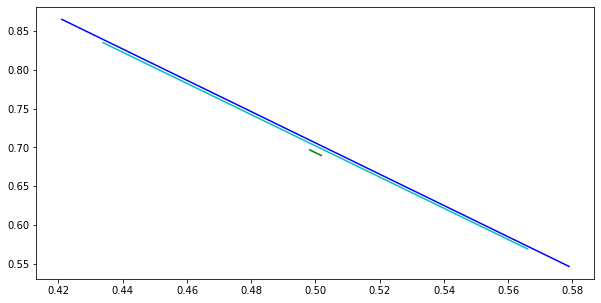

In [23]:
from sklearn.metrics import make_scorer, fbeta_score

def logloss(y_true, y_pred):
    
    return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

ds = df.loc[df['cardio'] == 1]
ds = ds[['age', 'weight', 'height', 'ap_lo', 'ap_hi']]

naive_x = naive.predict_proba(ds)[1]
neigh_x = neigh.predict_proba(ds)[1]
tree_x = tree.predict_proba(ds)[1]

print(naive_x)

x = np.linspace(0.01, 1, 100)
print(x)

plt.plot(naive_x, np.array([logloss(1, v) for v in naive_x]), 'g-', label='GaussianNB')

plt.plot(neigh_x, np.array([logloss(1, v) for v in neigh_x]), 'b-' ,label='KNeighborsClassifier')

plt.plot(tree_x, np.array([logloss(1, v) for v in tree_x]), 'c-', label='DecisionTreeClassifier')


plt.show()